In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore, pearsonr
import os
import random
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'

In [7]:
my_colors = {'NL_18':'tan', 
             'NL_25':'goldenrod', 
             'NL_27':'gold', 
             'FXS_421':'lightblue', 
             'FXS_426':'cornflowerblue', 
             'FXS_470':'b',
             'FXS_448':'purple'}
my_order = ('NL_18', 
             'NL_25', 
             'NL_27', 
             'FXS_421', 
             'FXS_426', 
             'FXS_470',
             'FXS_448')

In [8]:
MANE = pd.read_csv('MANE.GRCh38.v1.3.summary.txt', sep='\t')
MANE.rename(columns={'symbol': 'gene'}, inplace=True)
MANE['chr'] = 'chr' + MANE['GRCh38_chr'].str.extract(r'(NC_\d+)').squeeze().str.extract(r'NC_0*(\d+)')
MANE['length'] = abs(MANE['chr_start'] - MANE['chr_end'])
MANE['chr'] = MANE['chr'].replace({'chr23': 'chrX', 'chr24': 'chrY'})
MANE = MANE.dropna(subset=['chr'])
MANE = MANE.drop(columns=['RefSeq_nuc',
 'RefSeq_prot',
 'Ensembl_nuc',
 'Ensembl_prot',
 'MANE_status']).drop_duplicates()
genes = MANE[['gene', 'chr', 'chr_start', 'chr_end']].drop_duplicates()

In [10]:
control_domains = pd.read_csv('./RSEG/control_domains.bed', sep='\t', header=None, names=['chr', 'start', 'end'])
filtered_genes = pd.merge(
    genes,
    control_domains,
    on='chr',  
    suffixes=('', '_control')
)
filtered_genes = filtered_genes[
    (filtered_genes['chr_start'] >= filtered_genes['start']) &
    (filtered_genes['chr_end'] <= filtered_genes['end'])
]
invariant_genes = filtered_genes[['chr', 'start', 'end', 'gene']].drop_duplicates(subset=['gene'])

annotated_BREACHES = pd.read_csv('./annotated_BREACHES.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'coverage'])

filtered_genes = pd.merge(
    genes,
    annotated_BREACHES,
    on='chr',  
)
filtered_genes = filtered_genes[
    (filtered_genes['chr_start'] >= filtered_genes['start']) &
    (filtered_genes['chr_end'] <= filtered_genes['end'])
]
filtered_genes = filtered_genes[['chr', 'chr_start', 'chr_end', 'gene']]
filtered_genes = filtered_genes[~filtered_genes['gene'].isin(invariant_genes['gene'])]

In [11]:
bed_files = [f for f in os.listdir('./RSEG') if f.endswith('_BREACHes.bed')]

regions = {
    "gene_body": lambda row: (row['chr_start'], row['chr_end']),  # Entire gene body
    "promoter_10kb": lambda row: (row['chr_start'] - 2000, row['chr_start'] + 10000),  
}

result_df = filtered_genes[['gene', 'chr', 'chr_start', 'chr_end']].copy()
result_df[['gene_body', 'promoter_10kb']] = 0  # Add columns for regions

for bed_file in bed_files:
    bed_path = os.path.join('./RSEG', bed_file)
    
    # Load the BED file
    bed_df = pd.read_csv(bed_path, sep='\t', header=None, names=['chr', 'start', 'end'])
    
    for region_name, region_func in regions.items():
        # Iterate over each row in the result_df
        for idx, gene_row in result_df.iterrows():
            chr_gene = gene_row['chr']
            start_region, end_region = region_func(gene_row)  # Calculate region boundaries
            
            # Filter the BED file to get rows that match the same chromosome
            bed_chr = bed_df[bed_df['chr'] == chr_gene]
            
            for _, bed_row in bed_chr.iterrows():
                # Calculate overlap
                overlap_start = max(start_region, bed_row['start'])
                overlap_end = min(end_region, bed_row['end'])
                overlap_length = max(0, overlap_end - overlap_start)
                
                # Check if overlap is at least 90% of the region length
                region_length = end_region - start_region
                if overlap_length >= 0.9 * region_length:
                    result_df.at[idx, region_name] += 1
                    break  
final_df = result_df[['gene', 'gene_body', 'promoter_10kb']].query('gene_body > 0')

In [12]:
genes_NPC_CV = pd.read_csv('./genes_NPC_CV.txt', sep ='\t', index_col=False)
genes_NPC_CV['NPC_BREACH'] = genes_NPC_CV['gene'].isin(final_df['gene'])

([], [])

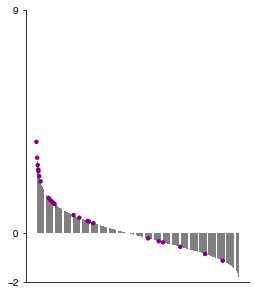

In [13]:
plt.figure(figsize=(4, 5))
sns.barplot(genes_NPC_CV.sort_values('cv_FXS_zscore', ascending = False), 
                x='gene', y='cv_FXS_zscore', edgecolor="none", color='grey')
sns.scatterplot(genes_NPC_CV.query('NPC_BREACH == True').sort_values('cv_FXS_zscore', ascending = False), 
                x='gene', y='cv_FXS_zscore', edgecolor="none", color='purple', s=20)

sns.despine(right=True)

plt.ylabel('')
plt.ylim(-2,9)
plt.yticks([-2,0,9])

plt.xlabel('')
plt.xticks([])
#plt.savefig('cv_FXS_zscore_ranked.pdf', dpi=1000)

In [14]:
sfari = pd.read_csv('SFARI-Gene_genes_01-13-2025release_01-15-2025export.csv')
genes_sfari = genes_NPC_CV.merge(sfari, left_on='gene', right_on='gene-symbol', how='left')
breach_data_sfari = genes_sfari.query('NPC_BREACH == True')

9
3
8
1
6
2


/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_58847/846219274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breach_data_sfari['cv_group'] = pd.cut(


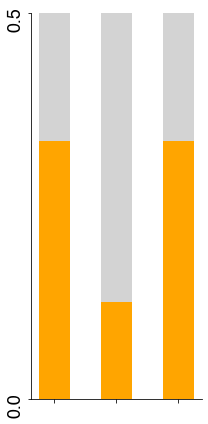

In [15]:
breach_data_sfari['cv_group'] = pd.cut(
    breach_data_sfari['cv_FXS_zscore'],
    bins=[-float('inf'), 0, 1.25, float('inf')],
    labels=['< 0', '>= 0 & <= 1.25', '> 1.25']
)

proportions = {'cv_group': [], 'either': [], 'neither': []}

for group in breach_data_sfari['cv_group'].unique():
    group_data = breach_data_sfari[breach_data_sfari['cv_group'] == group]
    total = len(group_data)
    print(total)
    if total > 0:
        either_count = ((group_data['gene-score'] < 3) | (group_data['syndromic'] == 1)).sum()
        print(either_count)
        neither_count = total - either_count
        proportions['cv_group'].append(group)
        proportions['either'].append(either_count / total)
        proportions['neither'].append(neither_count / total)
    else:
        proportions['cv_group'].append(group)
        proportions['either'].append(0)
        proportions['neither'].append(0)

proportions_df = pd.DataFrame(proportions)

fig, ax = plt.subplots(figsize=(3, 6))
bar_width = 0.5
x = range(len(proportions_df))

# Stack bars
ax.bar(x, proportions_df['either'], width=bar_width, label='Either gene-score or syndromic < 3', color='orange')
ax.bar(x, proportions_df['neither'], width=bar_width, bottom=proportions_df['either'], label='Neither', color='lightgrey')

ax.set_xticks(x)
ax.set_xticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 0.4)
plt.yticks([0, 0.5], rotation=90, fontsize=18)
plt.tight_layout()

#plt.savefig('sfari_S12.pdf', dpi=1000)
plt.show()

In [16]:
random.seed('ELIO')
filtered_df = genes_sfari[(genes_sfari['NPC_BREACH'] == False)]

empirical_samples = []
for _ in range(10000):
    sample = filtered_df.sample(n=9, replace=False)
    proportion = len(sample[(sample['gene-score'] < 3) | (sample['syndromic'] == 1)]) / 9
    empirical_samples.append(proportion)

high_zscore = genes_sfari[(genes_sfari['NPC_BREACH'] == True) & 
                          (genes_sfari['cv_FXS_zscore'] > 1.25)]
high_proportion = len(high_zscore[(high_zscore['gene-score'] < 3) | (high_zscore['syndromic'] == 1)]) / len(high_zscore)

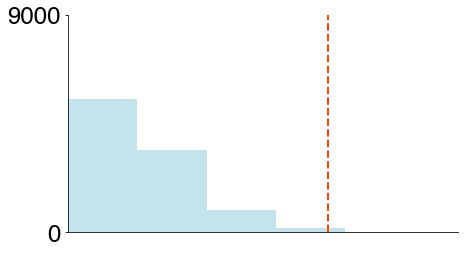

Empirical p-value for high zscore NPC_BREACH genes: 0.0177


In [17]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.hist(empirical_samples, bins=5, color='lightblue', alpha=0.7, label='10,000 draws of non-BREACH genes')
plt.axvline(high_proportion, color='orangered', linestyle='--', linewidth=2, label='High zscore NPC_BREACH genes')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([0, 9000], fontsize=24)
plt.xlim(0,0.5)
plt.xticks([],fontsize=24)
#plt.savefig('sfari_S12_histogram_top.pdf', dpi=1000)
plt.show()

high_pvalue = np.mean(np.array(empirical_samples) >= high_proportion)
print(f"Empirical p-value for high zscore NPC_BREACH genes: {high_pvalue}")

In [18]:
empirical_samples = []
for _ in range(10000):
    sample = filtered_df.sample(n=6, replace=False)
    proportion = len(sample[(sample['gene-score'] < 3) | (sample['syndromic'] == 1)]) / 6
    empirical_samples.append(proportion)

low_zscore = genes_sfari[(genes_sfari['NPC_BREACH'] == True) & 
                          (genes_sfari['cv_FXS_zscore'] < 0)]
low_proportion = len(low_zscore[(low_zscore['gene-score'] < 3) | (high_zscore['syndromic'] == 1)]) / len(low_zscore)

/var/folders/v1/3py01kc1619d4sj6bsmhx3br0000gn/T/ipykernel_58847/1201218879.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_proportion = len(low_zscore[(low_zscore['gene-score'] < 3) | (high_zscore['syndromic'] == 1)]) / len(low_zscore)


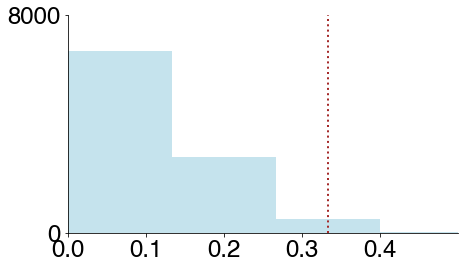

Empirical p-value for low zscore NPC_BREACH genes: 0.054


In [19]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.hist(empirical_samples, bins=5, color='lightblue', alpha=0.7, label='10,000 draws of non-BREACH genes')
plt.axvline(low_proportion, color='brown', linestyle=':', linewidth=2, label='Low zscore NPC_BREACH genes, N=20')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([0, 8000], fontsize=24)
plt.xlim(0,0.5)
plt.xticks([0,0.1,0.2,0.3,0.4],fontsize=24)
#plt.savefig('sfari_S12_histogram_bottom.pdf', dpi=1000)
plt.show()

low_pvalue = np.mean(np.array(empirical_samples) >= low_proportion)
print(f"Empirical p-value for low zscore NPC_BREACH genes: {low_pvalue}")

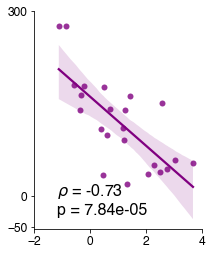

In [30]:
data = genes_NPC_CV.query('NPC_BREACH == True')
rho, pval = pearsonr(data['cv_FXS_zscore'], data['mean_diff'])

plt.figure(figsize=(3, 4))
sns.regplot(data=data, x='cv_FXS_zscore', y='mean_diff', scatter_kws={'linewidth': 0}, color='purple')
plt.ylabel('')
plt.xlabel('')
plt.xlim(-1.5, 4)
plt.xticks([-2,0,2,4],fontsize=12)
plt.yticks([-50, 0, 300], fontsize=12)
sns.despine(top=True, right=True)
plt.text(-1.2, -30, f"$\\rho$ = {rho:.2f}\np = {pval:.2e}", fontsize=16)

#plt.savefig('CV_zscore_deltaK9me3.pdf', dpi=1000)
plt.show()

In [51]:
RNAseq = pd.read_csv('DESEQ_melted.txt', sep='\t')
RNAseq['FXS'] = RNAseq['Genotype'].apply(lambda x: 'FXS' if 'FXS' in x else 'NL')
mean_signal_sums = RNAseq.groupby(['gene_name', 'FXS'])['value'].mean().reset_index()
mean_pivot = mean_signal_sums.pivot(index='gene_name', columns='FXS', values='value').reset_index()
mean_pivot['log2'] = np.log2(mean_pivot['FXS'] / mean_pivot['NL'])
numeric_cols = mean_pivot.select_dtypes(include=[np.number]) 
mean_pivot_cleaned = mean_pivot[np.isfinite(numeric_cols).all(axis=1)]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [55]:
mean_NL = RNAseq[RNAseq['FXS'] == 'NL'].groupby('gene_name')['value'].max()

def compute_repression(row):
    mean_nl_value = mean_NL.get(row['gene_name'], np.nan)
    if np.isnan(mean_nl_value) or row['value'] > mean_nl_value:
        return 0
    return row['value'] - mean_nl_value

RNAseq['reduction'] = RNAseq.apply(lambda row: compute_repression(row) if row['FXS'] == 'FXS' else np.nan, axis=1)

reduction_stats = RNAseq[RNAseq['FXS'] == 'FXS'].groupby('gene_name')['reduction'].agg(
    reduction_stdev='std',
).reset_index()

NPC_H3K9me3_RNA = genes_NPC_CV.merge(
    mean_pivot.merge(reduction_stats, on='gene_name', how='left'),
    left_on='gene', right_on='gene_name', 
    how='right', suffixes=('_H3K9me3', '_RNA')
)

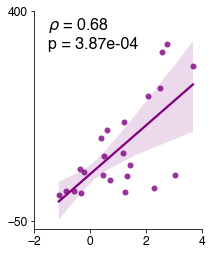

In [56]:
data = NPC_H3K9me3_RNA.query('NPC_BREACH == True')
rho, pval = pearsonr(data['cv_FXS_zscore'], data['reduction_stdev'])
plt.figure(figsize=(3, 4))
sns.regplot(data=data, x='cv_FXS_zscore', y='reduction_stdev', scatter_kws={'linewidth': 0}, color='purple')
plt.ylabel('')
plt.xlabel('')
plt.xlim(-1.5, 4)
plt.xticks([-2,0,2,4],fontsize=12)
plt.yticks([-50,400], fontsize=12)
#plt.ylim(-1, 0)
sns.despine(top=True, right=True)

plt.text(-1.5, 320, f"$\\rho$ = {rho:.2f}\np = {pval:.2e}", fontsize=16)
#plt.savefig('CV_zscore_mRNA_reduction.pdf', dpi=1000)
plt.show()

In [58]:
RNAseq = RNAseq.rename(columns={'gene_name': 'gene', 'Genotype': 'genotype'})
RNAseq_avg = RNAseq.groupby(['gene', 'genotype'])['value'].mean().reset_index()
iPSC_NPC_H3K9me3_2_10 = pd.read_csv('./NPC_H3K9me3_gene_signal_summation.txt', sep ='\t', index_col=False)
NPC_RNA_H3K9me3 = RNAseq_avg.merge(iPSC_NPC_H3K9me3_2_10, on=['gene', 'genotype'])

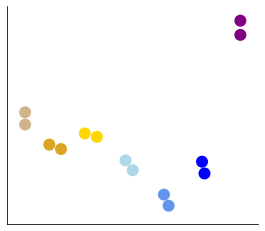

In [59]:
plt.figure(figsize=(4.5, 4))
s=sns.swarmplot(data=RNAseq.query("gene == 'STXBP6'"),
    x='genotype', y='value', hue='genotype', 
                palette=my_colors, 
                order=my_order,
                size=12)
s.set(title='')
s.set(xlabel=None) 
s.set(ylabel=None)
s.set_xticks([])
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
plt.ylim(0, 1800)
plt.yticks([], fontsize=20)
#s.figure.savefig('NPC_RNAseq_STXBP6.pdf',dpi=1000)
plt.show()

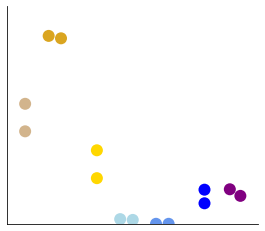

In [60]:
plt.figure(figsize=(4.5, 4))
s=sns.swarmplot(data=RNAseq.query("gene == 'TCERG1L'"),
    x='genotype', y='value', hue='genotype', 
                palette=my_colors, 
                order=my_order,
                size=12)
s.set(title='')
s.set(xlabel=None) 
s.set(ylabel=None)
s.set_xticks([])
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
plt.ylim(0, 80)
plt.yticks([], fontsize=20)
#s.figure.savefig('NPC_RNAseq_TCERG1L.pdf',dpi=1000)
plt.show()

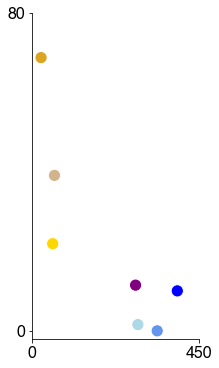

In [61]:
plt.figure(figsize=(3, 6))
gene_ids = ['TCERG1L']
filtered_df = NPC_RNA_H3K9me3.query("gene in @gene_ids")
s=sns.scatterplot(data=filtered_df,
    hue='genotype', x='signal_sum', y='value',
                  palette=my_colors,s=150, legend=False)



plt.xlim(0,450)
plt.xticks([0,450], fontsize=16)
plt.ylim(-2,80)
plt.yticks([0,80], fontsize=16)
plt.ylabel('')
plt.xlabel('')
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#plt.savefig('TCERG1L_RNA_K9me3.pdf', dpi=1000)
plt.show()

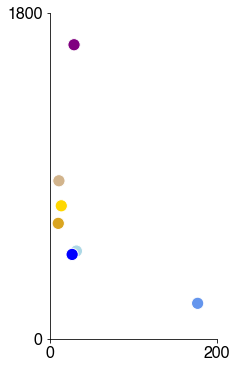

In [21]:
plt.figure(figsize=(3, 6))
gene_ids = ['STXBP6']
filtered_df = NPC_RNA_H3K9me3.query("gene in @gene_ids")
s=sns.scatterplot(data=filtered_df,
    hue='genotype', x='signal_sum', y='value',
                  palette=my_colors,s=150, legend=False)


plt.xlim(0,200)
plt.xticks([0,200], fontsize=16)
plt.ylim(0,1800)
plt.yticks([0,1800], fontsize=16)
plt.ylabel('')
plt.xlabel('')
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#plt.savefig('STXBP6_RNA_K9me3.pdf', dpi=1000)
plt.show()

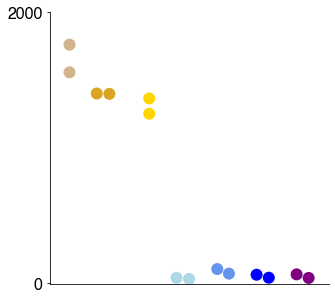

In [62]:
plt.figure(figsize=(5, 5))
s=sns.swarmplot(data=RNAseq.query("gene == 'FMR1'"),
    x='genotype', y='value', hue='genotype', 
                palette=my_colors, 
                order=my_order,
                size=12)
s.set(title='')
s.set(xlabel=None) 
s.set(ylabel=None)
s.set_xticks([])
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
plt.ylim(-10, 2000)
plt.yticks([0, 2000], fontsize=16)
#s.figure.savefig('NPC_RNAseq_FMR1.pdf',dpi=1000)
plt.show()

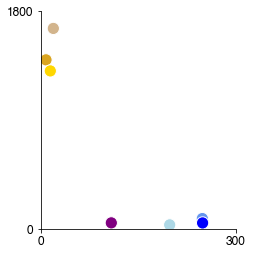

In [63]:
plt.figure(figsize=(3.5, 4))
gene_ids = ['FMR1']
filtered_df = NPC_RNA_H3K9me3.query("gene in @gene_ids")
s=sns.scatterplot(data=filtered_df,
    hue='genotype', x='signal_sum', y='value',
                  palette=my_colors,s=150, legend=False)


plt.xlim(0,300)
plt.xticks([0,300], fontsize=12)
plt.ylim(0,1800)
plt.yticks([0,1800], fontsize=12)
plt.ylabel('')
plt.xlabel('')
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#plt.savefig('FMR1_RNA_K9me3.pdf', dpi=1000)
plt.show()

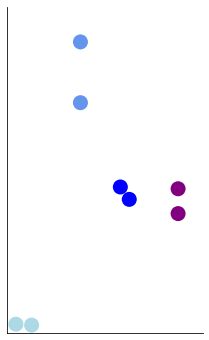

In [64]:
plt.figure(figsize=(3.5, 6))
s=sns.swarmplot(data=RNAseq.query("gene == 'SLITRK4'").query("not genotype.str.startswith('NL')"),
    x='genotype', y='value', hue='genotype', 
                palette=my_colors,
                size=15)
s.set(title='')
s.set(xlabel=None) 
s.set(ylabel=None)
s.set_xticks([])
plt.ylim(-10, 1100)
s.set_yticks([])
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#s.figure.savefig('FXS_iPSC-NPC_RNAseq_SLITRK4.pdf',dpi=1000)
plt.show()

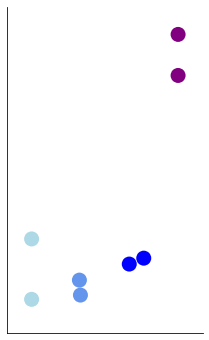

In [65]:
plt.figure(figsize=(3.5, 6))
s=sns.swarmplot(data=RNAseq.query("gene == 'SLITRK2'").query("not genotype.str.startswith('NL')"),
    x='genotype', y='value', hue='genotype', 
                palette=my_colors,
                size=15)
s.set(title='')
s.set(xlabel=None) 
s.set(ylabel=None)
s.set_xticks([])
plt.ylim(0, 120)
s.set_yticks([])
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#s.figure.savefig('FXS_iPSC-NPC_RNAseq_SLITRK2.pdf',dpi=1000)
plt.show()

-0.8229917092504975


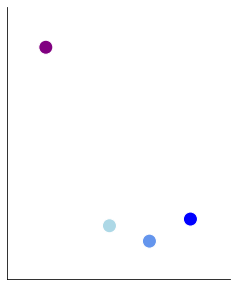

In [66]:
plt.figure(figsize=(4, 5))
gene_ids = ['SLITRK2']
filtered_df = NPC_RNA_H3K9me3.query("gene in @gene_ids").query("not genotype.str.startswith('NL')")
s=sns.scatterplot(data=filtered_df,
    hue='genotype', x='signal_sum', y='value',
                  palette=my_colors,s=200, legend=False)


plt.xlim(0,300)
plt.xticks([])
plt.ylim(0,120)
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
rho, pval = pearsonr(filtered_df['signal_sum'], filtered_df['value'])
print(rho)
#plt.savefig('SLITRK2_RNA_K9me3.pdf', dpi=1000)
plt.show()

-0.8799716200879896


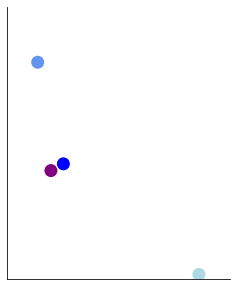

In [32]:
plt.figure(figsize=(4, 5))
gene_ids = ['SLITRK4']
filtered_df = NPC_RNA_H3K9me3.query("gene in @gene_ids").query("not genotype.str.startswith('NL')")
s=sns.scatterplot(data=filtered_df,
    hue='genotype', x='signal_sum', y='value',
                  palette=my_colors,s=200, legend=False)


plt.xlim(0,200)
plt.xticks([])
plt.ylim(0,1100)
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
rho, pval = pearsonr(filtered_df['signal_sum'], filtered_df['value'])
print(rho)
#plt.savefig('SLITRK4_RNA_K9me3.pdf', dpi=1000)
plt.show()

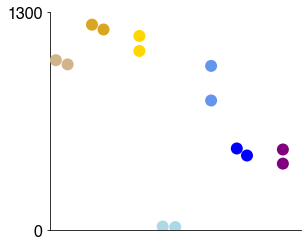

In [67]:
plt.figure(figsize=(4.5, 4))
s=sns.swarmplot(data=RNAseq.query("gene == 'SLITRK4'"),
    x='genotype', y='value', hue='genotype', 
                palette=my_colors, 
                order=my_order,
                size=12)
s.set(title='')
s.set(xlabel=None) 
s.set(ylabel=None)
s.set_xticks([])
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
plt.ylim(0, 1300)
plt.yticks([0,1300], fontsize=16)
#s.figure.savefig('NPC_RNAseq_SLITRK4.pdf',dpi=1000)
plt.show()

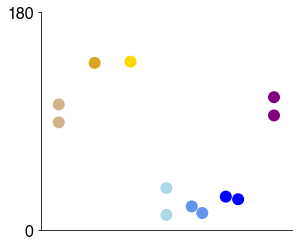

In [68]:
plt.figure(figsize=(4.5, 4))
s=sns.swarmplot(data=RNAseq.query("gene == 'SLITRK2'"),
    x='genotype', y='value', hue='genotype', 
                palette=my_colors, 
                order=my_order,
                size=12)
s.set(title='')
s.set(xlabel=None) 
s.set(ylabel=None)
s.set_xticks([])
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
plt.ylim(0, 180)
plt.yticks([0,180], fontsize=16)
#s.figure.savefig('NPC_RNAseq_SLITRK2.pdf',dpi=1000)
plt.show()

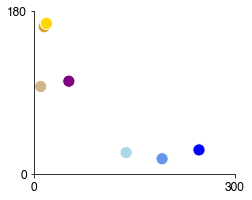

In [69]:
plt.figure(figsize=(3.6, 3))
gene_ids = ['SLITRK2']
filtered_df = NPC_RNA_H3K9me3.query("gene in @gene_ids")
s=sns.scatterplot(data=filtered_df,
    hue='genotype', x='signal_sum', y='value',
                  palette=my_colors,s=150, legend=False)


plt.xlim(0,300)
plt.xticks([0,300], fontsize=12)
plt.ylim(0,180)
plt.yticks([0,180], fontsize=12)
plt.ylabel('')
plt.xlabel('')
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#plt.savefig('SLITRK2_RNA_K9me3_NL.pdf', dpi=1000)
plt.show()

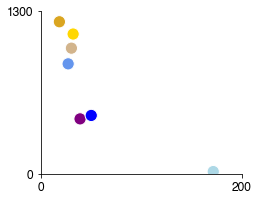

In [70]:
plt.figure(figsize=(3.6, 3))
gene_ids = ['SLITRK4']
filtered_df = NPC_RNA_H3K9me3.query("gene in @gene_ids")
s=sns.scatterplot(data=filtered_df,
    hue='genotype', x='signal_sum', y='value',
                  palette=my_colors,s=150, legend=False)


plt.xlim(0,200)
plt.xticks([0,200], fontsize=12)
plt.ylim(0,1300)
plt.yticks([0,1300], fontsize=12)
plt.ylabel('')
plt.xlabel('')
s.spines['top'].set_visible(False)
s.spines['right'].set_visible(False)
#plt.savefig('SLITRK4_RNA_K9me3_NL.pdf', dpi=1000)
plt.show()